### Setup Notebook

In [1]:
FROM_UPLOADED_FILE = False #@param {type:"boolean"}
UPLOADED_FILE_NAME = "/content/final_result_pruning.csv" #@param {type:"string"}

In [2]:
#@title Handle workspace
#@markdown ---
CLEAR_RESULTS_DIR = False      #@param {type:"boolean"}
RESULTS_DIR_PATH = "/content/results"      #@param {type:"string"}

In [3]:
if CLEAR_RESULTS_DIR:
    import os
    if os.path.exists(RESULTS_DIR_PATH) and os.path.isdir(RESULTS_DIR_PATH):
        print(f"Clearing {RESULTS_DIR_PATH}...")
        !rm -R {RESULTS_DIR_PATH}/*
        !rmdir {RESULTS_DIR_PATH}
        pass
    pass

### Imports

In [4]:
# Installing third party dependencies
print("Installing required libraries...")

old_requirements = '/content/tmp_requirements.txt'
!pip freeze > {old_requirements}
dependencies_list = "cmapy,sk-video,pytorch-model-summary,ConfigArgParse,tabulate,chart_studio,dash,dash_bootstrap_components".split(",")

with open(old_requirements) as f:
    old_requirements_list = f.read().split("\n")
    for a_req in dependencies_list:
        found_req = False
        for old_req in old_requirements_list:
            if old_req.startswith(a_req):
                print(f"{a_req} already installed!")
                found_req = True
                break
        if found_req is False:
            !pip install {a_req} -q
    pass
!rm -f {old_requirements}

Installing required libraries...
     |████████████████████████████████| 2.3MB 5.9MB/s 
     |████████████████████████████████| 51kB 2.7MB/s 
tabulate already installed!
     |████████████████████████████████| 71kB 3.5MB/s 
     |████████████████████████████████| 81kB 3.5MB/s 
     |████████████████████████████████| 1.0MB 8.4MB/s 
     |████████████████████████████████| 3.5MB 33.2MB/s 
     |████████████████████████████████| 194kB 46.6MB/s 
     |████████████████████████████████| 1.8MB 44.8MB/s 
     |████████████████████████████████| 358kB 45.5MB/s 
     |████████████████████████████████| 194kB 4.3MB/s 


In [5]:
from __future__ import print_function
from __future__ import division

# --------------------------------------------- #
# Standard Library, plus some Third Party Libraries
# --------------------------------------------- #

DASH_TEMPLATES_LIST = ["plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"]

from PIL import Image
from functools import partial
from pprint import pprint
from tqdm import tqdm
from typing import Tuple, Union


import configargparse
import copy
import collections
import datetime
import itertools
import functools
import h5py
import logging
import math
import os
import operator
import pickle
import random
import shutil
import sys
import re
import tabulate 
import time
# import visdom


from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------- #
# Data Science and Machine Learning Libraries
# --------------------------------------------- #
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

import numpy as np
import pandas as pd
import sklearn

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split

# --------------------------------------------- #
# Torch
# --------------------------------------------- #
try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    import torch.optim as optim
    from torch.utils.data import DataLoader, Dataset
    import torch.quantization
    import torch.nn.utils.prune as prune
except:
    print("torch not available!")
    pass


# --------------------------------------------- #
# Import: TorchVision
# --------------------------------------------- #
try:
    import torchvision
    from torchvision import datasets
    from torchvision import transforms
    from torchvision.transforms import Resize, Compose, ToTensor, CenterCrop, Normalize
    from torchvision.utils import save_image
except:
    print("torchvision library not available!")
    pass

# Plotly imports.
# ----------------------------------------------- #
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.express as px

# --------------------------------------------- #
# Import: skimage
# --------------------------------------------- #
try:
    import skimage
    import skimage.metrics as skmetrics
    from skimage.metrics import peak_signal_noise_ratio as psnr
    from skimage.metrics import structural_similarity as ssim
    from skimage.metrics import mean_squared_error
except:
    print("skimage library not available!")
    pass

## Checkout results

### Prepare DataFrame

In [6]:
import pandas as pd

In [7]:
df = pd.read_csv(f'{UPLOADED_FILE_NAME}').drop(['Unnamed: 0'], axis = 1)

In [8]:
df.head(5)

model_name       mse  ...  n_hl  tmp_footprint_p
0  1605077314-991078.32.5.arch_no_0.trial_no_0  0.000800  ...     5         1.000000
1  1605077314-991078.32.5.arch_no_0.trial_no_0  0.086294  ...     5         0.989959
2  1605077314-991078.32.5.arch_no_0.trial_no_0  0.157211  ...     5         0.989959
3  1605077314-991078.32.5.arch_no_0.trial_no_0  0.087492  ...     5         0.989959
4  1605077314-991078.32.5.arch_no_0.trial_no_0  0.080925  ...     5         0.989959

[5 rows x 15 columns]

In [9]:
df.tail(5)

model_name  ...  tmp_footprint_p
6243  1605077314-991078.32.12.arch_no_7.trial_no_0  ...         0.608457
6244  1605077314-991078.32.12.arch_no_7.trial_no_0  ...         0.608457
6245  1605077314-991078.32.12.arch_no_7.trial_no_0  ...         0.608457
6246  1605077314-991078.32.12.arch_no_7.trial_no_0  ...         0.608457
6247  1605077314-991078.32.12.arch_no_7.trial_no_0  ...         0.608457

[5 rows x 15 columns]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6248 entries, 0 to 6247
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   model_name           6248 non-null   object 
 1   mse                  6248 non-null   float64
 2   psnr_db              6248 non-null   float64
 3   ssim                 6248 non-null   float64
 4   eta_seconds          6248 non-null   float64
 5   footprint_byte       6248 non-null   int64  
 6   footprint_percent    6248 non-null   float64
 7   bpp                  6248 non-null   float64
 8   quant_tech           6248 non-null   object 
 9   quant_tech_2         6248 non-null   object 
 10  prune_amount         6240 non-null   float64
 11  size_by_weigths_bit  6248 non-null   int64  
 12  n_hf                 6248 non-null   int64  
 13  n_hl                 6248 non-null   int64  
 14  tmp_footprint_p      6248 non-null   float64
dtypes: float64(8), int64(4), object(3)
mem

In [11]:
df.describe()

mse      psnr_db  ...         n_hl  tmp_footprint_p
count  6248.000000  6248.000000  ...  6248.000000      6248.000000
mean      0.178397    20.022542  ...     8.500000         0.799824
std       0.171615    11.297812  ...     2.291471         0.250359
min       0.000279     5.957097  ...     5.000000         0.070286
25%       0.004645    10.890583  ...     6.750000         0.689151
50%       0.130239    14.877566  ...     8.500000         0.929907
75%       0.325885    29.350887  ...    10.250000         0.988843
max       1.014938    41.562062  ...    12.000000         1.000000

[8 rows x 12 columns]

In [12]:
set(df["quant_tech"])

{'Basic', 'L1Unstructured', 'RandomUnstructured'}

In [13]:
set(df["model_name"])

{'1605077314-991078.32.10.arch_no_5.trial_no_0',
 '1605077314-991078.32.11.arch_no_6.trial_no_0',
 '1605077314-991078.32.12.arch_no_7.trial_no_0',
 '1605077314-991078.32.5.arch_no_0.trial_no_0',
 '1605077314-991078.32.6.arch_no_1.trial_no_0',
 '1605077314-991078.32.7.arch_no_2.trial_no_0',
 '1605077314-991078.32.8.arch_no_3.trial_no_0',
 '1605077314-991078.32.9.arch_no_4.trial_no_0'}

In [14]:
if FROM_UPLOADED_FILE == False:
    columns = df.columns
    RecordDataFrame = collections.namedtuple('RecordDataFrame', columns)
    def get_size_by_weigths_bits(a_row):
        a_record = RecordDataFrame._make(a_row)
        model_name = a_record.model_name
        hf = int(model_name.split(".")[1])
        hl = int(model_name.split(".")[2])
        weigths_no = (hf * 2 + 1) + (hf*hf*hl + hf*hl) + (hf+1)
        if a_record.quant_tech_2 == 'Basic':
            return weigths_no * 4 * 8
        if a_record.quant_tech_2.endswith('_abs'):
            return (weigths_no - int(a_record.prune_amount)) * 4 * 8
        if a_record.quant_tech_2.endswith('_rate'):
            return int(weigths_no - weigths_no * a_record.prune_amount) * 4 * 8
        return np.nan
    df['size_by_weigths_bit'] = list(map(get_size_by_weigths_bits, df.values))
    pass

In [15]:
def get_n_hf(a_row):
    return int(a_row[0].split(".")[1])
def get_n_hl(a_row):
    return int(a_row[0].split(".")[2])

df["n_hf"] = list(map(get_n_hf, df.values))
df["n_hl"] = list(map(get_n_hl, df.values))

In [16]:
df.head(5)

model_name       mse  ...  n_hl  tmp_footprint_p
0  1605077314-991078.32.5.arch_no_0.trial_no_0  0.000800  ...     5         1.000000
1  1605077314-991078.32.5.arch_no_0.trial_no_0  0.086294  ...     5         0.989959
2  1605077314-991078.32.5.arch_no_0.trial_no_0  0.157211  ...     5         0.989959
3  1605077314-991078.32.5.arch_no_0.trial_no_0  0.087492  ...     5         0.989959
4  1605077314-991078.32.5.arch_no_0.trial_no_0  0.080925  ...     5         0.989959

[5 rows x 15 columns]

In [17]:
df.tail(5)

model_name  ...  tmp_footprint_p
6243  1605077314-991078.32.12.arch_no_7.trial_no_0  ...         0.608457
6244  1605077314-991078.32.12.arch_no_7.trial_no_0  ...         0.608457
6245  1605077314-991078.32.12.arch_no_7.trial_no_0  ...         0.608457
6246  1605077314-991078.32.12.arch_no_7.trial_no_0  ...         0.608457
6247  1605077314-991078.32.12.arch_no_7.trial_no_0  ...         0.608457

[5 rows x 15 columns]

In [18]:
if FROM_UPLOADED_FILE == False:
    tmp_df = df.set_index(['model_name'])
    for a_index in set(tmp_df.index):
        # print(tmp_df.loc[a_index,:]['size_by_weigths_bit'].values.max())
        tmp_res = tmp_df.loc[a_index,:]['size_by_weigths_bit'].values / (tmp_df.loc[a_index,:]['size_by_weigths_bit'].values.max())
        tmp_df.loc[a_index, ["tmp_footprint_p"]]= tmp_res
        pass
    pass

In [19]:
if FROM_UPLOADED_FILE == False:
    tmp_df.head(5)

In [20]:
if FROM_UPLOADED_FILE == False:
    tmp_df.tail(5)

In [21]:
if FROM_UPLOADED_FILE == False:
    df = tmp_df.reset_index()

In [22]:
if FROM_UPLOADED_FILE == False:
    df['bpp'] = df['size_by_weigths_bit'].values / (256*256)

### Plots

In [23]:
hover_labels = ["bpp", "psnr_db", "quant_tech_2", "prune_amount", "n_hf", "n_hl"]
hue = 'quant_tech'; x = 'bpp'; y = 'psnr_db'
fig = px.scatter(df[df[f"{hue}"] != 'Basic'], x=f"{x}", y=f"{y}", color=f"{hue}", 
                 # marginal_y="violin", marginal_x="box", trendline="ols",
                 hover_data = hover_labels,
                 template=DASH_TEMPLATES_LIST[2])
fig.update_layout(template = DASH_TEMPLATES_LIST[2], title_text=f'{y.upper()} | Groupped by {hue} | dataframes')

In [24]:
hue = 'quant_tech_2'; x = 'bpp'; y = 'psnr_db'
fig = px.scatter(df[df[f"{hue}"] != 'Basic'], x=f"{x}", y=f"{y}", color=f"{hue}", 
                 # marginal_y="violin", marginal_x="box", trendline="ols",
                 hover_data = hover_labels,
                 template=DASH_TEMPLATES_LIST[2])
fig.update_layout(template = DASH_TEMPLATES_LIST[2], title_text=f'{y.upper()} | Groupped by {hue} | dataframes')

In [25]:
hue = 'quant_tech'; x = 'bpp'; y = 'psnr_db'
fig = px.box(df[df[f"{hue}"] != 'Basic'], y=f"{y}", color=f"{hue}", 
                 # marginal_y="violin", marginal_x="box", trendline="ols",
                 template=DASH_TEMPLATES_LIST[2])
fig.update_layout(template = DASH_TEMPLATES_LIST[2], title_text=f'{y.upper()} | Groupped by {hue} | dataframes')

In [26]:
hue = 'quant_tech_2'; x = 'bpp'; y = 'psnr_db'
fig = px.box(df[df[f"{hue}"] != 'Basic'], y=f"{y}", color=f"{hue}", 
                 # marginal_y="violin", marginal_x="box", trendline="ols",
                 template=DASH_TEMPLATES_LIST[2])
fig.update_layout(template = DASH_TEMPLATES_LIST[2], title_text=f'{y.upper()} | Groupped by {hue} | dataframes')

In [27]:
hue = 'quant_tech'; x = 'bpp'; y = 'psnr_db'
fig = px.violin(df[df[f"{hue}"] != 'Basic' ], y=f"{y}", color=f"{hue}", 
                 # marginal_y="violin", marginal_x="box", trendline="ols",
                 template=DASH_TEMPLATES_LIST[2])
fig.update_layout(template = DASH_TEMPLATES_LIST[2], title_text=f'{y.upper()} | Groupped by {hue} | dataframes')

In [28]:
hue = 'quant_tech_2'; x = 'bpp'; y = 'psnr_db'
fig = px.violin(df[df[f"{hue}"] != 'Basic' ], y=f"{y}", color=f"{hue}", 
                 # marginal_y="violin", marginal_x="box", trendline="ols",
                 template=DASH_TEMPLATES_LIST[2])
fig.update_layout(template = DASH_TEMPLATES_LIST[2], title_text=f'{y.upper()} | Groupped by {hue} | dataframes')

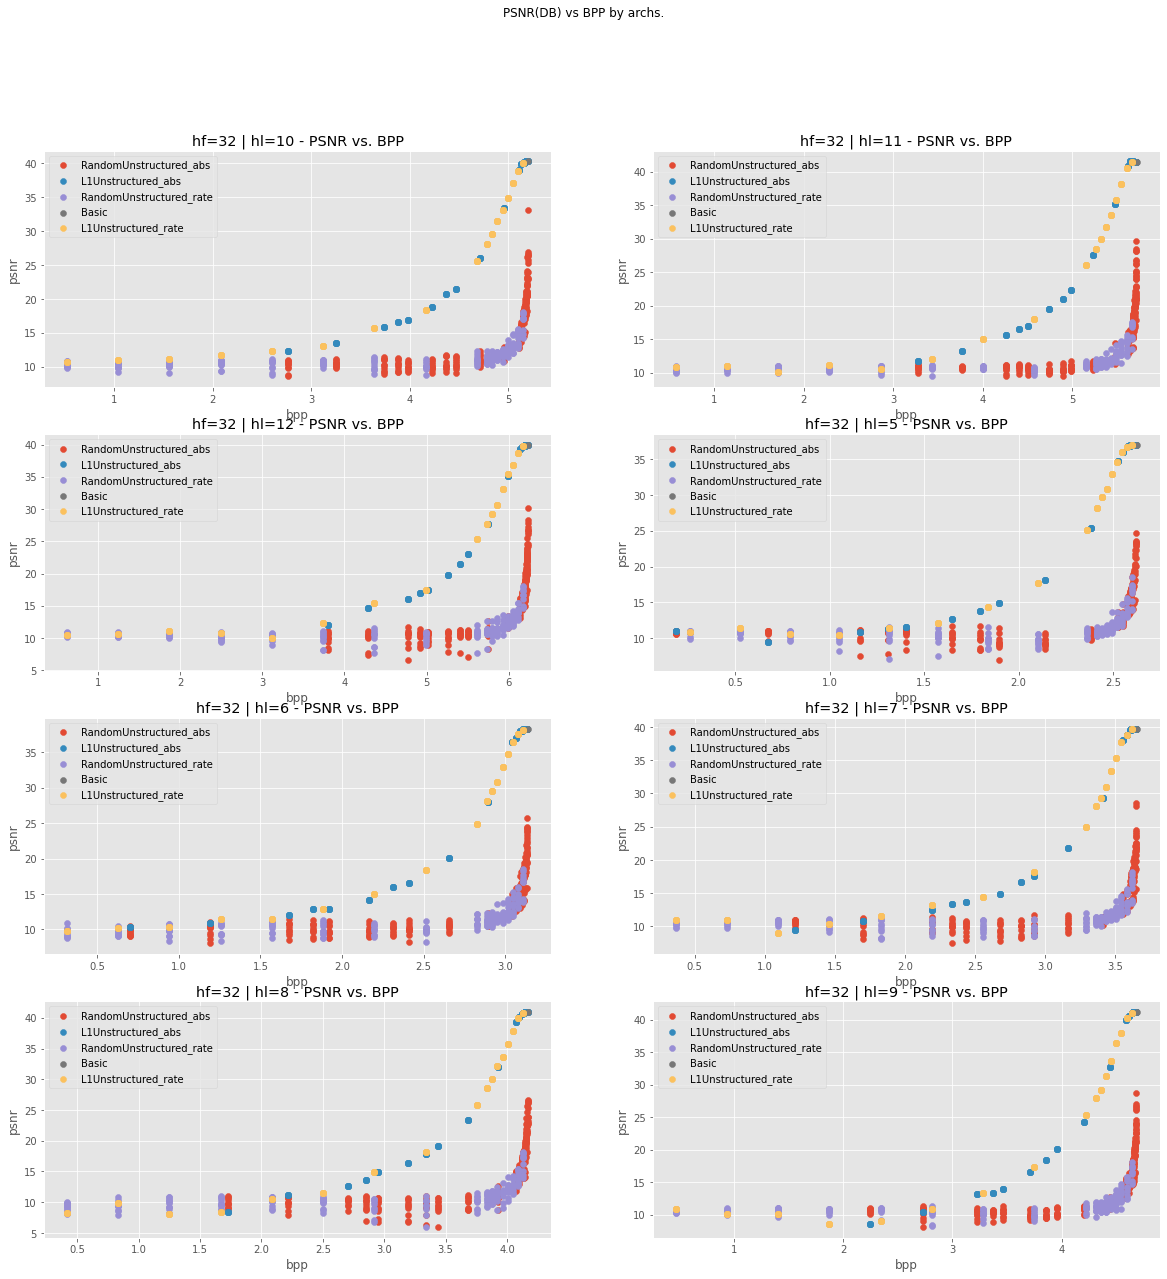

In [29]:
hue = 'quant_tech_2';
tmp_df = df.set_index(['model_name'])
n = len(set(tmp_df.index))
n = n // 2 if n % 2 == 0 else n // 2 + 1

fig, axes = plt.subplots(n, 2, figsize = (20, 20))
axes_list = list(itertools.chain(*axes))
fig.suptitle("PSNR(DB) vs BPP by archs.")

for pos, a_index in enumerate(sorted(set(tmp_df.index))):
    a_group = tmp_df.loc[a_index,:]
    labels = set(a_group[f'{hue}'])
    
    ax = axes_list[pos]
    for a_label in labels:
        bpp_psnr_p = a_group[a_group[f'{hue}'] == a_label][["bpp", "psnr_db"]]
        ax.scatter(bpp_psnr_p['bpp'].values, bpp_psnr_p['psnr_db'].values, label=a_label)
        hf = str(a_index).split(".")[1]; hl = str(a_index).split(".")[2]
        pass
        ax.set_xlabel('bpp'); ax.set_ylabel('psnr'); 
        ax.set_title(f'hf={hf} | hl={hl} - PSNR vs. BPP');
        ax.legend()
    pass
plt.show()

In [30]:
# fig = px.scatter(df, x="bpp", y="psnr_db", facet_col="model_name")
fig = px.scatter(df, x="bpp", y="psnr_db", facet_col="quant_tech", color=f"quant_tech_2", template=DASH_TEMPLATES_LIST[2])
fig.update_layout(template = DASH_TEMPLATES_LIST[2], title_text=f'Prune RandomUnstructured ({y.upper()} vs {x.upper()})')
fig.show()

In [31]:
df_tmp = df[(df["quant_tech"] == "RandomUnstructured") | (df["quant_tech"] == "Basic")]
hover_labels = ["bpp", "psnr_db", "quant_tech_2", "prune_amount", "n_hf", "n_hl"]
x = "bpp"; y = "psnr_db";
fig = px.scatter(
    df_tmp, x="bpp", y="psnr_db", color="quant_tech_2",
    template=DASH_TEMPLATES_LIST[2],
    hover_data=df_tmp[hover_labels])
fig.update_layout(template = DASH_TEMPLATES_LIST[2], title_text=f'Prune RandomUnstructured ({y.upper()} vs {x.upper()})')
fig.show()

In [32]:
df_tmp = df[(df["quant_tech"] == "L1Unstructured") | (df["quant_tech"] == "Basic")]
hover_labels = ["bpp", "psnr_db", "quant_tech_2", "prune_amount", "n_hf", "n_hl"]
x = "bpp"; y = "psnr_db";
fig = px.scatter(
    df_tmp, x="bpp", y="psnr_db", color="quant_tech_2", 
    hover_data=df_tmp[hover_labels],
    template=DASH_TEMPLATES_LIST[2],)
fig.update_layout(template = DASH_TEMPLATES_LIST[2], title_text=f'Prune L1Unstructured ({y.upper()} vs {x.upper()})')
fig.show()

In [33]:
n_hl_min = df["n_hl"].values.min()
n_hl_max = df["n_hl"].values.max()
tmp_list = list(set(df["n_hl"].values))
n_hl_medium = tmp_list[len(tmp_list)//2]

condition_selection = \
    ((df["quant_tech"] == "RandomUnstructured") | (df["quant_tech"] == "Basic")) \
    & ((df["n_hl"] == n_hl_min) | (df["n_hl"] == n_hl_medium) | (df["n_hl"] == n_hl_max))
df_tmp = df[condition_selection]
hover_labels = ["bpp", "psnr_db", "quant_tech_2", "prune_amount", "n_hf", "n_hl"]
x = "bpp"; y = "psnr_db";
fig = px.scatter(
    df_tmp, x="bpp", y="psnr_db", color="quant_tech_2", 
    hover_data=df_tmp[hover_labels],
    template=DASH_TEMPLATES_LIST[2],)
fig.update_layout(template = DASH_TEMPLATES_LIST[2], title_text=f'Prune RandomUnstructured ({y.upper()} vs {x.upper()})')
fig.show()

In [34]:
n_hl_min = df["n_hl"].values.min()
n_hl_max = df["n_hl"].values.max()
tmp_list = list(set(df["n_hl"].values))
n_hl_medium = tmp_list[len(tmp_list)//2]

condition_selection = \
    ((df["quant_tech"] == "L1Unstructured") | (df["quant_tech"] == "Basic")) \
    & ((df["n_hl"] == n_hl_min) | (df["n_hl"] == n_hl_medium) | (df["n_hl"] == n_hl_max))
df_tmp = df[condition_selection]
hover_labels = ["bpp", "psnr_db", "quant_tech_2", "prune_amount", "n_hf", "n_hl"]
x = "bpp"; y = "psnr_db";
fig = px.scatter(
    df_tmp, x="bpp", y="psnr_db", color="quant_tech_2", 
    hover_data=df_tmp[hover_labels],
    template=DASH_TEMPLATES_LIST[2],)
fig.update_layout(template = DASH_TEMPLATES_LIST[2], title_text=f'Prune L1Unstructured ({y.upper()} vs {x.upper()})')
fig.show()

In [35]:
n_hl_min = df["n_hl"].values.min()
n_hl_max = df["n_hl"].values.max()
tmp_list = list(set(df["n_hl"].values))
n_hl_medium = tmp_list[len(tmp_list)//2]

condition_selection = \
    ((df["quant_tech"] == "RandomUnstructured") | (df["quant_tech"] == "Basic")) \
    & ((df["n_hl"] == n_hl_min) | (df["n_hl"] == n_hl_medium) | (df["n_hl"] == n_hl_max))
df_tmp = df[condition_selection]
hover_labels = ["bpp", "psnr_db", "quant_tech_2", "prune_amount", "n_hf", "n_hl"]
x = "bpp"; y = "psnr_db";
hist_data = []
group_labels = set(df_tmp["quant_tech_2"].values)
for a_label in group_labels:
    print(a_label)
    hist_data.append(df_tmp[df_tmp["quant_tech_2"] == str(a_label)][y].values)
    pass
fig = ff.create_distplot(
    hist_data = hist_data, group_labels = list(group_labels))
fig.update_layout(template = DASH_TEMPLATES_LIST[2], title_text=f'Prune RandomUnstructured ({y.upper()})')
fig.show()

RandomUnstructured_rate
RandomUnstructured_abs
Basic


In [36]:
n_hl_min = df["n_hl"].values.min()
n_hl_max = df["n_hl"].values.max()
tmp_list = list(set(df["n_hl"].values))
n_hl_medium = tmp_list[len(tmp_list)//2]

condition_selection = \
    ((df["quant_tech"] == "L1Unstructured") | (df["quant_tech"] == "Basic")) \
    & ((df["n_hl"] == n_hl_min) | (df["n_hl"] == n_hl_medium) | (df["n_hl"] == n_hl_max))
df_tmp = df[condition_selection]
hover_labels = ["bpp", "psnr_db", "quant_tech_2", "prune_amount", "n_hf", "n_hl"]
x = "bpp"; y = "psnr_db";
hist_data = []
group_labels = set(df_tmp["quant_tech_2"].values)
for a_label in group_labels:
    print(a_label)
    hist_data.append(df_tmp[df_tmp["quant_tech_2"] == str(a_label)][y].values)
    pass
fig = ff.create_distplot(
    hist_data = hist_data, group_labels = list(group_labels))
fig.update_layout(template = DASH_TEMPLATES_LIST[2], title_text=f'Prune L1Unstructured ({y.upper()})')
fig.show()

L1Unstructured_abs
Basic
L1Unstructured_rate


In [37]:
n_hl_min = df["n_hl"].values.min()
n_hl_max = df["n_hl"].values.max()
tmp_list = list(set(df["n_hl"].values))
n_hl_medium = tmp_list[len(tmp_list)//2]

condition_selection = \
    ((df["quant_tech"] == "RandomUnstructured") | (df["quant_tech"] == "Basic")) \
    & ((df["n_hl"] == n_hl_min) | (df["n_hl"] == n_hl_medium) | (df["n_hl"] == n_hl_max))
df_tmp = df[condition_selection]

In [38]:
columns = list(df_tmp.columns)
def divide_by_hl_size(a_row, columns = columns):
    n_hl = columns.index("n_hl")
    quant_tech_2 = columns.index("quant_tech_2")
    if a_row[quant_tech_2] == 'Basic': return a_row[quant_tech_2]
    return a_row[quant_tech_2] + "-" + str(a_row[n_hl])

df_tmp["label_by_tech_hl"] = list(map(divide_by_hl_size, df_tmp.values))

In [39]:
x = "bpp"; y = "psnr_db";
hist_data = []
group_labels = set(df_tmp["label_by_tech_hl"].values)
for a_label in group_labels:
    print(a_label)
    hist_data.append(df_tmp[df_tmp["label_by_tech_hl"] == str(a_label)][y].values)
    pass
fig = ff.create_distplot(
    hist_data = hist_data,
    group_labels = list(group_labels))
fig.update_layout(template = DASH_TEMPLATES_LIST[2], title_text=f'Prune RandomUnstructured ({y.upper()})')
fig.show()

RandomUnstructured_abs-5
RandomUnstructured_rate-12
RandomUnstructured_abs-9
RandomUnstructured_rate-5
RandomUnstructured_rate-9
Basic
RandomUnstructured_abs-12


In [40]:
n_hl_min = df["n_hl"].values.min()
n_hl_max = df["n_hl"].values.max()
tmp_list = list(set(df["n_hl"].values))
n_hl_medium = tmp_list[len(tmp_list)//2]

condition_selection = \
    ((df["quant_tech"] == "L1Unstructured") | (df["quant_tech"] == "Basic")) \
    & ((df["n_hl"] == n_hl_min) | (df["n_hl"] == n_hl_medium) | (df["n_hl"] == n_hl_max))
df_tmp = df[condition_selection]

In [41]:
columns = list(df_tmp.columns)
def divide_by_hl_size(a_row, columns = columns):
    n_hl = columns.index("n_hl")
    quant_tech_2 = columns.index("quant_tech_2")
    if a_row[quant_tech_2] == 'Basic': return a_row[quant_tech_2]
    return a_row[quant_tech_2] + "-" + str(a_row[n_hl])

df_tmp["label_by_tech_hl"] = list(map(divide_by_hl_size, df_tmp.values))

In [42]:
x = "bpp"; y = "psnr_db";
hist_data = []
group_labels = set(df_tmp["label_by_tech_hl"].values)
for a_label in group_labels:
    print(a_label)
    hist_data.append(df_tmp[df_tmp["label_by_tech_hl"] == str(a_label)][y].values)
    pass
fig = ff.create_distplot(
    hist_data = hist_data,
    group_labels = list(group_labels))
fig.update_layout(template = DASH_TEMPLATES_LIST[2], title_text=f'Prune L1Unstructured ({y.upper()})')
fig.show()

L1Unstructured_rate-9
L1Unstructured_rate-12
L1Unstructured_abs-12
L1Unstructured_abs-5
L1Unstructured_abs-9
Basic
L1Unstructured_rate-5


In [43]:
stop_val = (24*2 + 2) + (24*24*5 + 24*5) + (24 + 1)
# np.logspace(1, stop_val, num=10, endpoint=False)
np.unique(np.linspace(1, stop_val, num=50, endpoint=False).astype(dtype = np.int))

array([   1,   62,  123,  185,  246,  308,  369,  431,  492,  554,  615,
        677,  738,  800,  861,  923,  984, 1046, 1107, 1169, 1230, 1292,
       1353, 1415, 1476, 1538, 1599, 1660, 1722, 1783, 1845, 1906, 1968,
       2029, 2091, 2152, 2214, 2275, 2337, 2398, 2460, 2521, 2583, 2644,
       2706, 2767, 2829, 2890, 2952, 3013])

In [44]:
np.unique(np.logspace(1, int(np.log10(stop_val)), num=100, endpoint=False).astype(dtype = np.int))

array([ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
        23,  25,  26,  27,  28,  30,  31,  33,  34,  36,  38,  39,  41,
        43,  45,  47,  50,  52,  54,  57,  60,  63,  66,  69,  72,  75,
        79,  83,  87,  91,  95, 100, 104, 109, 114, 120, 125, 131, 138,
       144, 151, 158, 165, 173, 181, 190, 199, 208, 218, 229, 239, 251,
       263, 275, 288, 301, 316, 331, 346, 363, 380, 398, 416, 436, 457,
       478, 501, 524, 549, 575, 602, 630, 660, 691, 724, 758, 794, 831,
       870, 912, 954])

## Save results

In [45]:
df.to_csv("/content/final_result_tmp.csv")